##  Calculate the surface area over the Earth of an array of lat/lon pixels ##

Code by Benjamin A. Laken

This is an implementation of the code from [BADAC](http://badc.nerc.ac.uk/help/coordinates/cell-surf-area.html).
It calculates an array of surface area of a given lat/lon dimension, and also an array of factors, with which you can calculate an area-averaged value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def area_of_cell(radlon1, radlon2, sinlat1, sinlat2, R=6367.4447):
    """
    Calculate the surface area (km²) of a given gridcell. 
    When given the e/w bounding (radlon2, radlon1) in radians,
    and the n/s bounding (sinlat2, sinlat1) in sin latitude.
    The constant R is by default equal to 1 Earth radius.
    """
    return (R**2)*(radlon2-radlon1)*(sinlat2-sinlat1) 

def get_surface_area(lat, lon, chatty=True):
    """
    Input: A pair of integers specifying the number of pixels in the latitude and
            longitude dimension of a grid. 
    Output: Two 2D arrays, returing the physical area (km²) of the grid (surface_area),
            and a factor (factor_surface), used to weight an array for area-averaging. 
    """
    surface_area = np.zeros([lat, lon])
    factor_surface = np.zeros([lat, lon])
    lon_step = 360 / lon
    lat_step = 180 / lat      
    e_bound = [(((i+1) * lon_step) - lon_step) * np.pi / 180 for i in range(lon)]
    w_bound = [((i+1) * lon_step) * np.pi / 180 for i in range(lon)]
    n_bound = [np.sin((90 - (i * lat_step)) * np.pi / 180) for i in range(lat)]
    s_bound = [np.sin((90 - ((i + 1) * lat_step)) * np.pi / 180) for i in range(lat)]
    for i in range(lat):
        surface_area[i,0]=area_of_cell(e_bound[0], w_bound[0], s_bound[i], n_bound[i]) 
        surface_area[i,1:] = surface_area[i,0]  # Repeat the first column along the array
    total_area = np.sum(surface_area)
    # Nb. this assertion is only valid if you intend to calculate area over the whole globe...
    assert abs(total_area - 510100000) < 1000000, "Error: Area calc. off by more than 1×10⁶ km²"
    factor_surface = surface_area/surface_area[int(lat/2), int(lon/2)]
    if chatty:
        print('Grid resolution is {0} × {1}'.format(lon_step, lat_step))
        print('Calculated area is {0:3.1e} km² (actual is 5.1×10⁸ km²)'.format(total_area)) 
        print('Pixel area at center {0:4.3e} km², weight {1:3.2f}'.format(surface_area[int(lat/2),0], factor_surface[int(lat/2),0]))
        print('Pixel area at edge {0:4.3e} km², weight {1:3.2f}'.format(surface_area[0,0],factor_surface[0,0]))
    return surface_area, factor_surface

In [22]:
sa, fs = get_surface_area(lat=180,lon=360, chatty=True)

Grid resolution is 1.0 × 1.0
Calculated area is 5.1e+08 km² (actual is 5.1×10⁸ km²)
Pixel area at center 1.235e+04 km², weight 1.00
Pixel area at edge 1.078e+02 km², weight 0.01


In [23]:
%%timeit
_ = get_surface_area(lat=180,lon=360, chatty=False) # Demonstration of running speed...

1000 loops, best of 3: 1.24 ms per loop


### Plot example output using basemap ###

In [6]:
from mpl_toolkits.basemap import Basemap

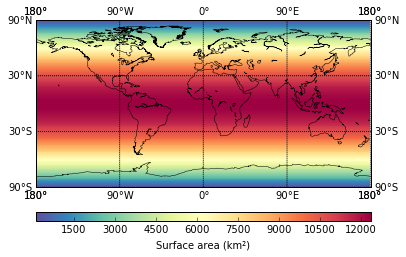

In [58]:
lat, lon = sa.shape
lons = np.arange(-180, 180, 360/lon)
lats = np.arange(-90, 90, 180/lat)
m = Basemap(projection='cyl', resolution='c',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91.,60.),labels=[1,1,0,0],fontsize=10)
m.drawmeridians(np.arange(0.,361.,90.),labels=[0,0,1,1],fontsize=10)
m.pcolormesh(lons[:],lats[:],sa,cmap=plt.cm.Spectral_r)
cbar = m.colorbar(location='bottom',pad='15%')
cbar.set_label('Surface area (km²)')